## Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import random # random class
import warnings
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.stats import linregress
from tqdm import tqdm # loop progress

from fredapi import Fred

In [2]:
# set your Eikon API app key
import eikon as ek
#ek.set_app_key("d9b8f435f4694441a667806b4245931101403e3e") # this will not work for you if you dont have an refinitiv account, you need to enter your personal API key here
ek.set_app_key("f47c330480d74c598b7e8ebc2539424e91764dd8") # Ginevra

## 1. Get sp500 constituents from eikon

In [3]:
# function to download data
def GetStockData(ticker, start, end, interval):
        temp_data = ek.get_timeseries([ticker], 
                                      start_date = start, 
                                      end_date = end, 
                                      interval=interval)
        return temp_data

In [4]:
import datetime
# create a list of dates
start_date = datetime.date(2023, 4, 1)
end_date = start_date #datetime.date.today()

date_list = []
for year in range(start_date.year, end_date.year + 1):
    for month in range(1, 13):
        if year == start_date.year and month < start_date.month:
            continue
        elif year == end_date.year and month > end_date.month:
            break
        else:
            date_list.append(datetime.date(year, month, 1).strftime('%Y-%m-%d'))
date_list

['2023-04-01']

In [5]:
# get constituents for specific dates
Ticker_ISIN_GICSSector_dict = {}

for date in tqdm(date_list):
    temp_data = ek.get_data('.SPX', ['TR.IndexConstituentRIC', 'TR.IndexConstituentName'], {'SDate':date})[0]
    riclist = temp_data['Constituent RIC'].tolist()
    temp_data_2 = ek.get_data(riclist, ['TR.ISIN', 'TR.GICSSector'])
    Ticker_ISIN_GICSSector_dict[date] = temp_data_2



100%|██████████| 1/1 [00:23<00:00, 23.01s/it]


In [6]:
# get the unique lists
isin_set = set()
ticker_set = set()
for date in Ticker_ISIN_GICSSector_dict:
    if isinstance(Ticker_ISIN_GICSSector_dict[date], tuple):
        isin_data = Ticker_ISIN_GICSSector_dict[date][0][['ISIN']]
        ticker_data = Ticker_ISIN_GICSSector_dict[date][0][['Instrument']]
    else:
        isin_data = Ticker_ISIN_GICSSector_dict[date][['ISIN']]
        ticker_data = Ticker_ISIN_GICSSector_dict[date][['Instrument']]
    isin_set.update(isin_data['ISIN'].tolist())
    ticker_set.update(ticker_data['Instrument'].tolist())

isin_df = pd.DataFrame({'ISIN': list(isin_set)})
isin_list = list(isin_set)
ticker_list = list(ticker_set)

In [7]:
# create a df with all close prices

# define the parameters for getting the stock data
start_date = "2019-12-31"
end_date = "2023-03-31"
interval = "daily"

# create an empty dictionary to store the resulting dataframes
result_dict = {}
# loop through the ticker list and call the function for each ticker
for ticker in ticker_list:
    try:
        result_dict[ticker] = GetStockData(ticker, start_date, end_date, interval)
        print(ticker, "downloaded successfully")
    except:
        print(ticker, "not successful")
        continue

PEP.OQ downloaded successfully
CDW.OQ downloaded successfully
USB.N downloaded successfully
RF.N downloaded successfully
AAL.OQ downloaded successfully
PSA.N downloaded successfully
FTV.N downloaded successfully
BWA.N downloaded successfully
KR.N downloaded successfully
SWK.N downloaded successfully
PCG.N downloaded successfully
CLX.N downloaded successfully
PPG.N downloaded successfully
CCI.N downloaded successfully
CPRI.N downloaded successfully
ATVI.OQ downloaded successfully
IEX.N downloaded successfully
ABC.N downloaded successfully
ITW.N downloaded successfully
MNST.OQ downloaded successfully
DFS.N downloaded successfully
BKNG.OQ downloaded successfully
DOW.N downloaded successfully
MSCI.N downloaded successfully
IR.N downloaded successfully
BKR.OQ downloaded successfully
UHS.N downloaded successfully
QRVO.OQ downloaded successfully
CHRW.OQ downloaded successfully
FICO.N downloaded successfully
AMCR.N downloaded successfully
RE.N downloaded successfully
BDX.N downloaded successfu

In [8]:
# get all close prices to one dataframe
df_list = []

# Iterate over the dictionary items and reset the index of each DataFrame
for key, value in result_dict.items():
    value = value.reset_index()
    # Select the 'Date' and 'CLOSE' columns
    value = value[['Date', 'CLOSE']]
    # Rename the 'CLOSE' column to the key
    value = value.rename(columns={'CLOSE': key})
    # Set the 'Date' column as the index
    value = value.set_index('Date')
    # Add the DataFrame to the list
    df_list.append(value)

# Join the DataFrames on the index with an outer join
result_df = df_list[0]
for i in range(1, len(df_list)):
    result_df = result_df.join(df_list[i], how='outer')

# get rid of incomplete columns
result_df_clean = result_df.loc[:, result_df.count() == max(result_df.describe().T["count"])]
nans_count = result_df_clean.isna().sum().sum()
print("Number of NaN values in result_df:", nans_count)

Number of NaN values in result_df: 0


In [9]:
# get 5 day returns
weekly_returns = result_df_clean.pct_change().rolling(window=5).sum()

In [10]:
# set the file path to where you want to save the DataFrame
path = 'Dataframes/'
file_name = 'clean_data_sp500_{}.csv'
file_path = path + file_name
# save the DataFrame to a CSV file with a timestamp index and current date and time in the filename
result_df_clean.round(2).to_csv(file_path, index_label='timestamp', date_format='%Y-%m-%d')

In [11]:
# load data from desktop
path = 'Dataframes/clean_data_sp500_{}.csv'
result_df_clean = pd.read_csv(path)
result_df_clean = result_df_clean.set_index('timestamp')

In [12]:
# get 5 day returns
weekly_returns = result_df_clean.pct_change().rolling(window=5).sum()

# define the type of change should be used
target = weekly_returns

## 2. Get GICS Sectors

In [13]:
# eikon (ignore)

sector_classes_code, err = ek.get_data(target.columns.tolist(), 
                                       ['TR.GICSSectorCode', 'TR.GICSIndustryGroupCode', 
                                        'TR.GICSIndustryCode', 'TR.GICSSubIndustryCode'])
sector_classes, err = ek.get_data(target.columns.tolist(), 
                                  ['TR.GICSSector', 'TR.GICSIndustryGroup', 
                                   'TR.GICSIndustry', 'TR.GICSSubIndustry'])

## 3. Get idiosyncratic features

In [14]:
fields = [
    "TR.ROAActValue",
    "TR.PriceToSalesPerShare",
    "TR.TotalDebtToEV",
    "TR.PriceToBVPerShare", 
    "TR.CompanyMarketCapitalization", 
    "TR.PriceNetChg30D", 
    "TR.AvgDailyValTraded30D", 
    "TR.SharpeRatioWkly2Y", 
    "TR.Volatility260D", 
    "TR.BetaWklyUp2Y", 
    "TR.BetaWklyDown2Y", 
    "TR.RSISimple14D", 
    "TR.ShortInterestPCT", 
    "TR.ShortInterestDTC"
]

In [15]:
df2, e = ek.get_data('0#.SPX', fields, parameters={'SDate': '2022-12-31', 'EDate':'2022-12-31'}) #took latest date from train period as single data point for idiosyncratic features
df2 = df2.set_index(df2.columns[0])
df2['Return On Assets - Actual'].fillna(df2['Return On Assets - Actual'].median(), inplace=True)
df2_without_nan = df2.dropna()
#rename a few columns
df2_without_nan = df2_without_nan.rename(columns={'Price To Sales Per Share (Daily Time Series Ratio)': 'Price To Sales Per Share'})
df2_without_nan = df2_without_nan.rename(columns={'Total Debt To Enterprise Value (Daily Time Series Ratio)': 'Total Debt To Enterprise Value'})
df2_without_nan = df2_without_nan.rename(columns={'Price To Book Value Per Share (Daily Time Series Ratio)': 'Price To Book Value Per Share'})

## 4. Feature Visualisations

In [16]:
def sigmoid(x):
    x = 1 / (1 + np.exp(-x))
    return x

idio_feats = df2_without_nan.astype(float)

#ln transformation with negatives
ln_transform_list = ["Price To Sales Per Share",
                     "Total Debt To Enterprise Value",
                     "Price To Book Value Per Share",
                     "Company Market Capitalization",
                     "Average Daily Value Traded - 30 Days"]
for i in ln_transform_list:
    idio_feats.loc[:, i] = np.where(idio_feats[i] <= 0, 0, np.log(1+idio_feats[i]))

# price change transform
idio_feats.loc[:, "Trailing 30-day Price Net Change"] = np.clip(0.01*idio_feats["Trailing 30-day Price Net Change"], -0.5, 0.5)

# new feature: convexity 
idio_feats.loc[:, "Convexity"] = (idio_feats["Weekly Beta Up - 2 Year"] / idio_feats["Weekly Beta Down - 2 Year"])
idio_feats = idio_feats.drop(['Weekly Beta Up - 2 Year', 'Weekly Beta Down - 2 Year'], axis=1)
idio_feats.loc[:, "Convexity"] = sigmoid(idio_feats.loc[:, "Convexity"])
# short interest features
idio_feats.loc[:, "Days To Cover"] = np.log(1+idio_feats["Days To Cover"])
idio_feats.loc[:, "Short Interest Pct"] = np.log(idio_feats["Short Interest Pct"])

# profitability
idio_feats.loc[:, "Return On Assets - Actual"] = np.clip(np.log(1+idio_feats["Return On Assets - Actual"]*0.01), -0.1,1)

# vola
idio_feats.loc[:, "Volatility - 260 days"] = np.log(idio_feats["Volatility - 260 days"])

# standardize each row
idio_feats = idio_feats.apply(zscore)

/Users/ginevrabramante/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


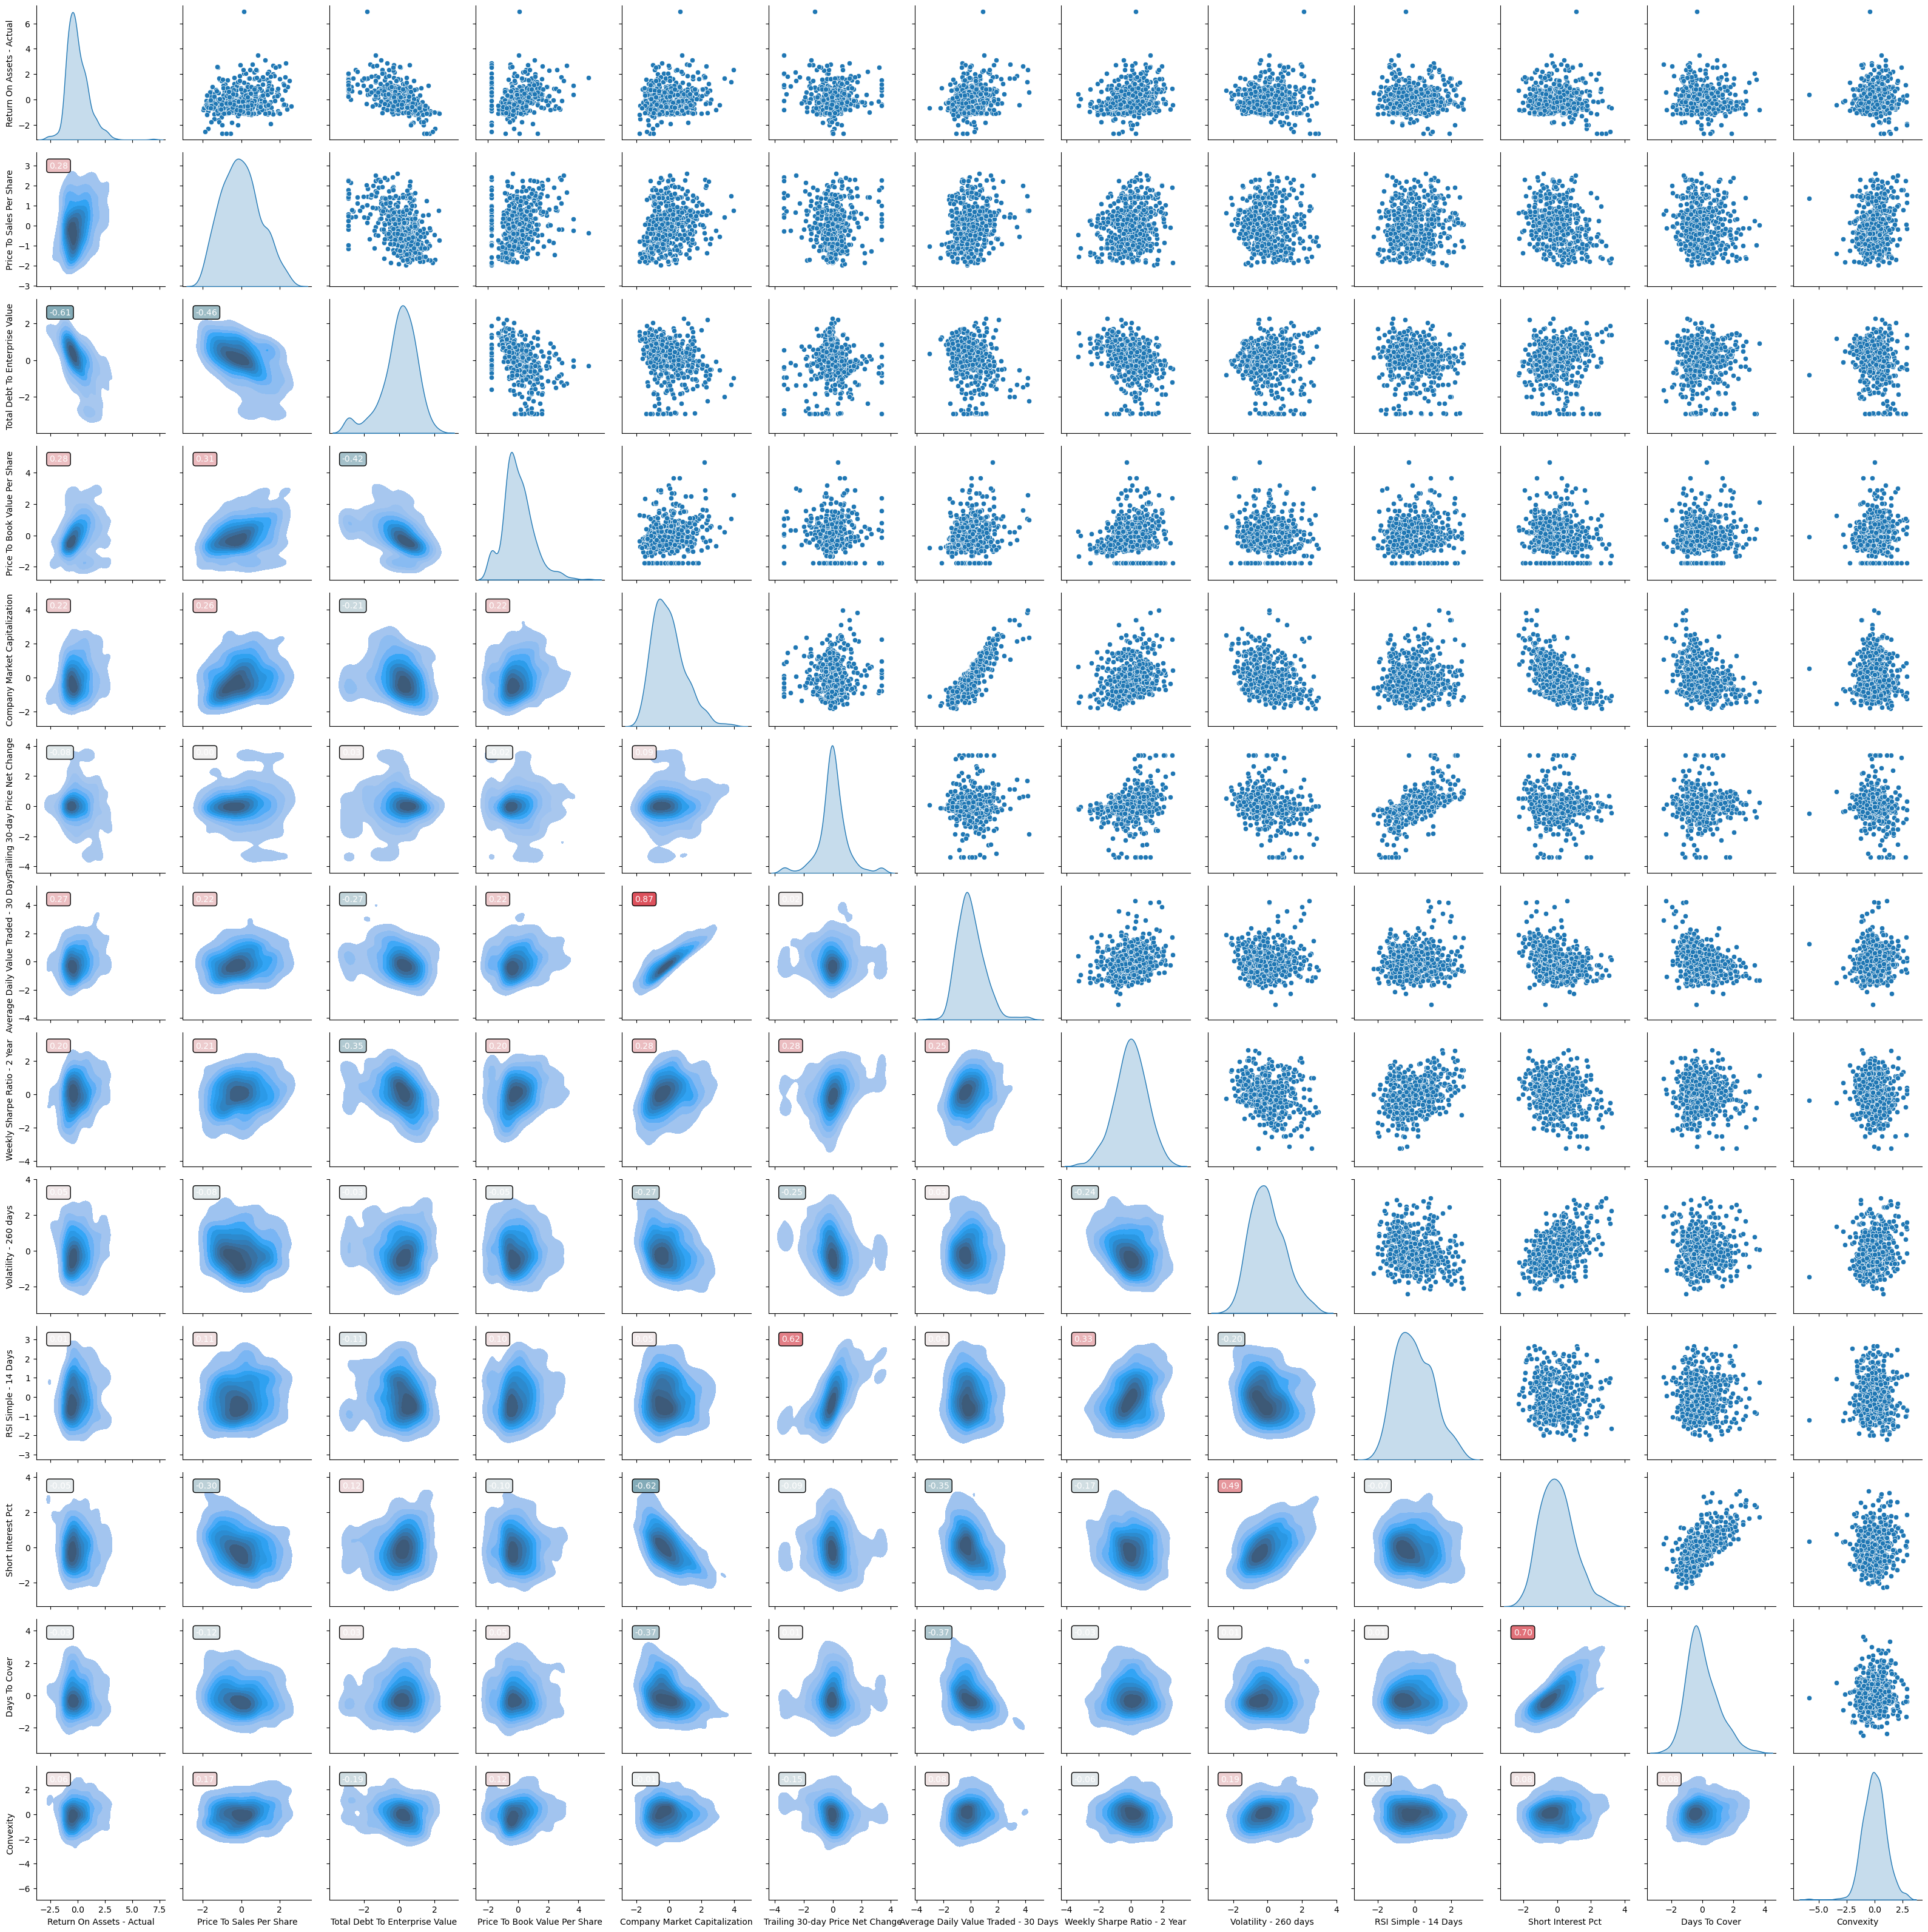

In [17]:
# idiosyncratic feature plot
warnings.filterwarnings("ignore")

# Load data
df = idio_feats

# Plot time series on diagonal
g = sns.PairGrid(df, diag_sharey=False)

# Add correlation coefficients to lower triangle with colors
corr_matrix = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, j in zip(*np.tril_indices_from(g.axes)):
    if i != j:
        coef = corr_matrix.iloc[i, j]
        g.axes[i, j].annotate(f"{coef:.2f}", (0.1, 0.9), xycoords='axes fraction', ha='left', va='center', color='w', fontsize=10, bbox=dict(boxstyle="round", facecolor=cmap(coef/2 + 0.5), alpha=1))

g.map_upper(sns.scatterplot)
#g.map_lower(sns.histplot, color='steelblue', bins=20, edgecolor='white')
g.map_lower(sns.kdeplot, shade=True)
g.map_diag(sns.kdeplot, shade=True)


plt.show()

warnings.filterwarnings("default")

In [18]:
# set the file path to where you want to save the DataFrame
path = 'Dataframes/'
file_name = 'idi_features{}.csv'
file_path = path + file_name
# save the DataFrame to a CSV file with a timestamp index and current date and time in the filename
df2_without_nan.round(5).to_csv(file_path, index_label='timestamp', date_format='%Y-%m-%d')

## 5. Get Macroeconomic Sensitivities

In [19]:
# import FRED data
fred = Fred(api_key = "4a017ca39a1f96774f9587e5956bfd6b") # API key

In [20]:
# function to get a dataframe with the variables
def create_table(series, column_name):
    df = series.to_frame()
    df = df.reset_index()
    df = df.rename(columns={"index": "date", 0: column_name})
    return df.set_index("date")

In [21]:
# variables: "ticker": "clear_name"
x_factors_dict = {
    "SP500": "S&P500", #risk
    "VIXCLS": "VIX", #risk
    
    "DGS10": "_10_y_UST", #rate
    "T10Y2Y": "_2s10s_UST", #rate
    "T10YIE": "_10_y_BE", #rate
    
    "DEXUSEU": "USD_to_EUR", #fx
    "DEXUSUK": "USD_to_GBP", #fx
    "DEXJPUS": "JPY_to_USD", #fx
    "DEXCHUS": "CNH_to_USD", #fx
    "DEXMXUS": "MXN_to_USD", #fx
    "DEXCAUS": "CAD_to_USD", #fx
    
    "DCOILBRENTEU": "Brent_Crude", #cmdty
    
    "WILLLRGCAP": "Large", #factor
    "WILLSMLCAP": "Small", #factor
    "WILLLRGCAPVAL": "Value", #factor
    "WILLLRGCAPGR": "Growth" #factor
}

why these variables?

#risk: overall equity market exposure

#rate: overall (real)rate and inflation exposure

#fx: mayjor currencies and neighbours currencies (some US stocks might be dependend on other regions)

#factor: small cap premium and value premium

In [22]:
# this will download the data. for each variable the total history will be downloaded!
dfs = []
for fred_series_id, column_name in x_factors_dict.items():
    series = fred.get_series(fred_series_id)
    df = create_table(series, column_name)
    dfs.append(df)

df = pd.concat(dfs, axis=1)

# we fill NaN with the previous value
df_filled = df.fillna(method='ffill')

In [23]:
#a little feature engineering (takes a few seconds)
df_filled["ValueOverGrowth"] = df_filled["Value"]/df_filled["Growth"]
df_filled["SmallOverLarge"] = df_filled["Small"]/df_filled["Large"]
df_filled["_10_y_UST_real"] = df_filled["_10_y_UST"]-df_filled["_10_y_BE"]
df_raw_features = df_filled.drop(['Large', 'Small', 'Value', 'Growth'], axis=1)

new_order = ["S&P500", "VIX", "ValueOverGrowth", "SmallOverLarge", "USD_to_EUR", 
             "USD_to_GBP", "JPY_to_USD", "CNH_to_USD", "MXN_to_USD", "CAD_to_USD",
             "_10_y_UST", "_10_y_UST_real", "_10_y_BE", "_2s10s_UST", "Brent_Crude"]

df_raw_features = df_raw_features[new_order]
df_raw_features

S&P500    VIX  ValueOverGrowth  SmallOverLarge  USD_to_EUR  \
date                                                                      
1962-01-02      NaN    NaN              NaN             NaN         NaN   
1962-01-03      NaN    NaN              NaN             NaN         NaN   
1962-01-04      NaN    NaN              NaN             NaN         NaN   
1962-01-05      NaN    NaN              NaN             NaN         NaN   
1962-01-08      NaN    NaN              NaN             NaN         NaN   
...             ...    ...              ...             ...         ...   
2023-05-08  4138.12  16.98         0.834192        1.076623      1.1026   
2023-05-09  4119.17  17.71         0.834044        1.077234      1.1026   
2023-05-10  4137.64  16.94         0.825716        1.077093      1.1026   
2023-05-11  4130.62  16.93         0.818508        1.069486      1.1026   
2023-05-12  4124.08  16.93         0.818508        1.069486      1.1026   

            USD_to_GBP  JPY_to_USD  CNH_to_USD  MXN_to_USD  CAD_to_USD  \
date                                                                     
1962-01-02         NaN         NaN         NaN         NaN         NaN   
1962-01-03         NaN         NaN         NaN         NaN         NaN   
1962-01-04         NaN         NaN         NaN         NaN         NaN   
1962-01-05         NaN         NaN         NaN         NaN         NaN   
1962-01-08         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-05-08       1.265      134.85      6.9101     17.7481      1.3419   
2023-05-09       1.265      134.85      6.9101     17.7481      1.3419   
2023-05-10       1.265      134.85      6.9101     17.7481      1.3419   
2023-05-11       1.265      134.85      6.9101     17.7481      1.3419   
2023-05-12       1.265      134.85      6.9101     17.7481      1.3419   

            _10_y_UST  _10_y_UST_real  _10_y_BE  _2s10s_UST  Brent_Crude  
date                                                                      
1962-01-02       4.06             NaN       NaN         NaN          NaN  
1962-01-03       4.03             NaN       NaN         NaN          NaN  
1962-01-04       3.99             NaN       NaN         NaN          NaN  
1962-01-05       4.02             NaN       NaN         NaN          NaN  
1962-01-08       4.03             NaN       NaN         NaN          NaN  
...               ...             ...       ...         ...          ...  
2023-05-08       3.52            1.29      2.23       -0.48        75.85  
2023-05-09       3.53            1.30      2.23       -0.48        75.85  
2023-05-10       3.43            1.26      2.17       -0.47        75.85  
2023-05-11       3.39            1.23      2.16       -0.50        75.85  
2023-05-12       3.39            1.21      2.18       -0.52        75.85  

[16009 rows x 15 columns]

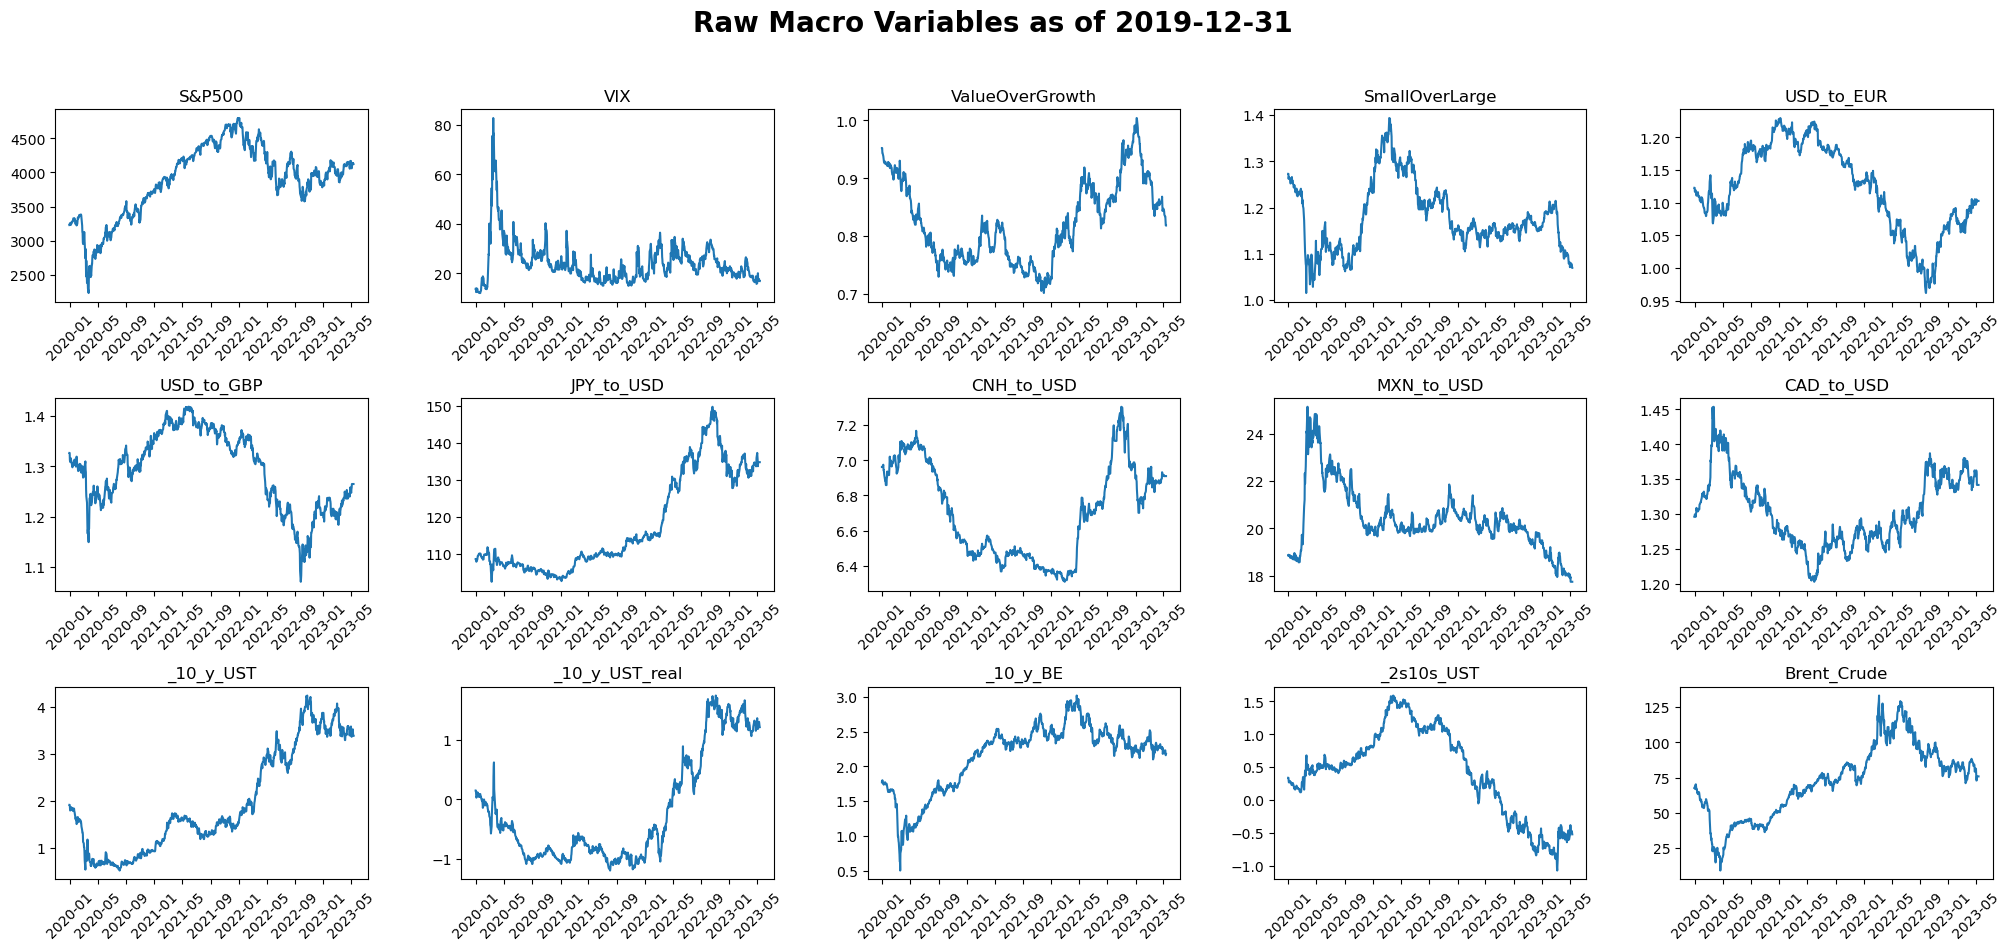

In [24]:
#visualizing all raw features (this takes a few seconds)
as_of = '2019-12-31'
df = df_raw_features[df_raw_features.index >= as_of]

# define the number of rows and columns for the plot grid
nrows = 3
ncols = 5

# create a new figure and axes
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 10))

# flatten the axes array for easier indexing
axs = axs.flatten()

# iterate over the columns and create subplots
for i, col in enumerate(df.columns):
    ax = axs[i]
    sns.lineplot(x=df.index, y=col, data=df, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)  # set the x-tick label rotation to 45 degrees
    ax.set_ylabel('')

# hide the unused subplots
for i in range(len(df.columns), nrows*ncols):
    axs[i].axis('off')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# add a title to the plot grid
fig.suptitle('Raw Macro Variables as of ' + as_of, fontsize=20, fontweight='bold')

# display the plot
plt.show()

In [25]:
# and slice the dateframe to the period we want
# start_date = "2019-12-31" end_date = "2023-03-31" is used in the initial data sourcing from eikon

start_date = "2019-12-31"
end_date = "2023-03-31"

df_raw_features_slice = df_raw_features.loc[start_date:end_date]

In [26]:
#calculate the changes

abs_changes = ["VIX", "_10_y_UST", "_10_y_UST_real", "_10_y_BE", "_2s10s_UST"] # here it doesn't make sense to take relative changes so we calculate the differences
rel_changes = ["S&P500", "ValueOverGrowth", "SmallOverLarge", "USD_to_EUR", "USD_to_GBP",
               "JPY_to_USD", "CNH_to_USD", "MXN_to_USD", "CAD_to_USD","Brent_Crude"]

df_raw_features_slice_chg = df_raw_features_slice.copy()
df_raw_features_slice_chg.loc[:, rel_changes] = df_raw_features_slice[rel_changes].pct_change().rolling(window=5).sum()
df_raw_features_slice_chg.loc[:, abs_changes] = df_raw_features_slice[abs_changes].diff().rolling(window=5).sum()

## 6. Plotting the macro variables

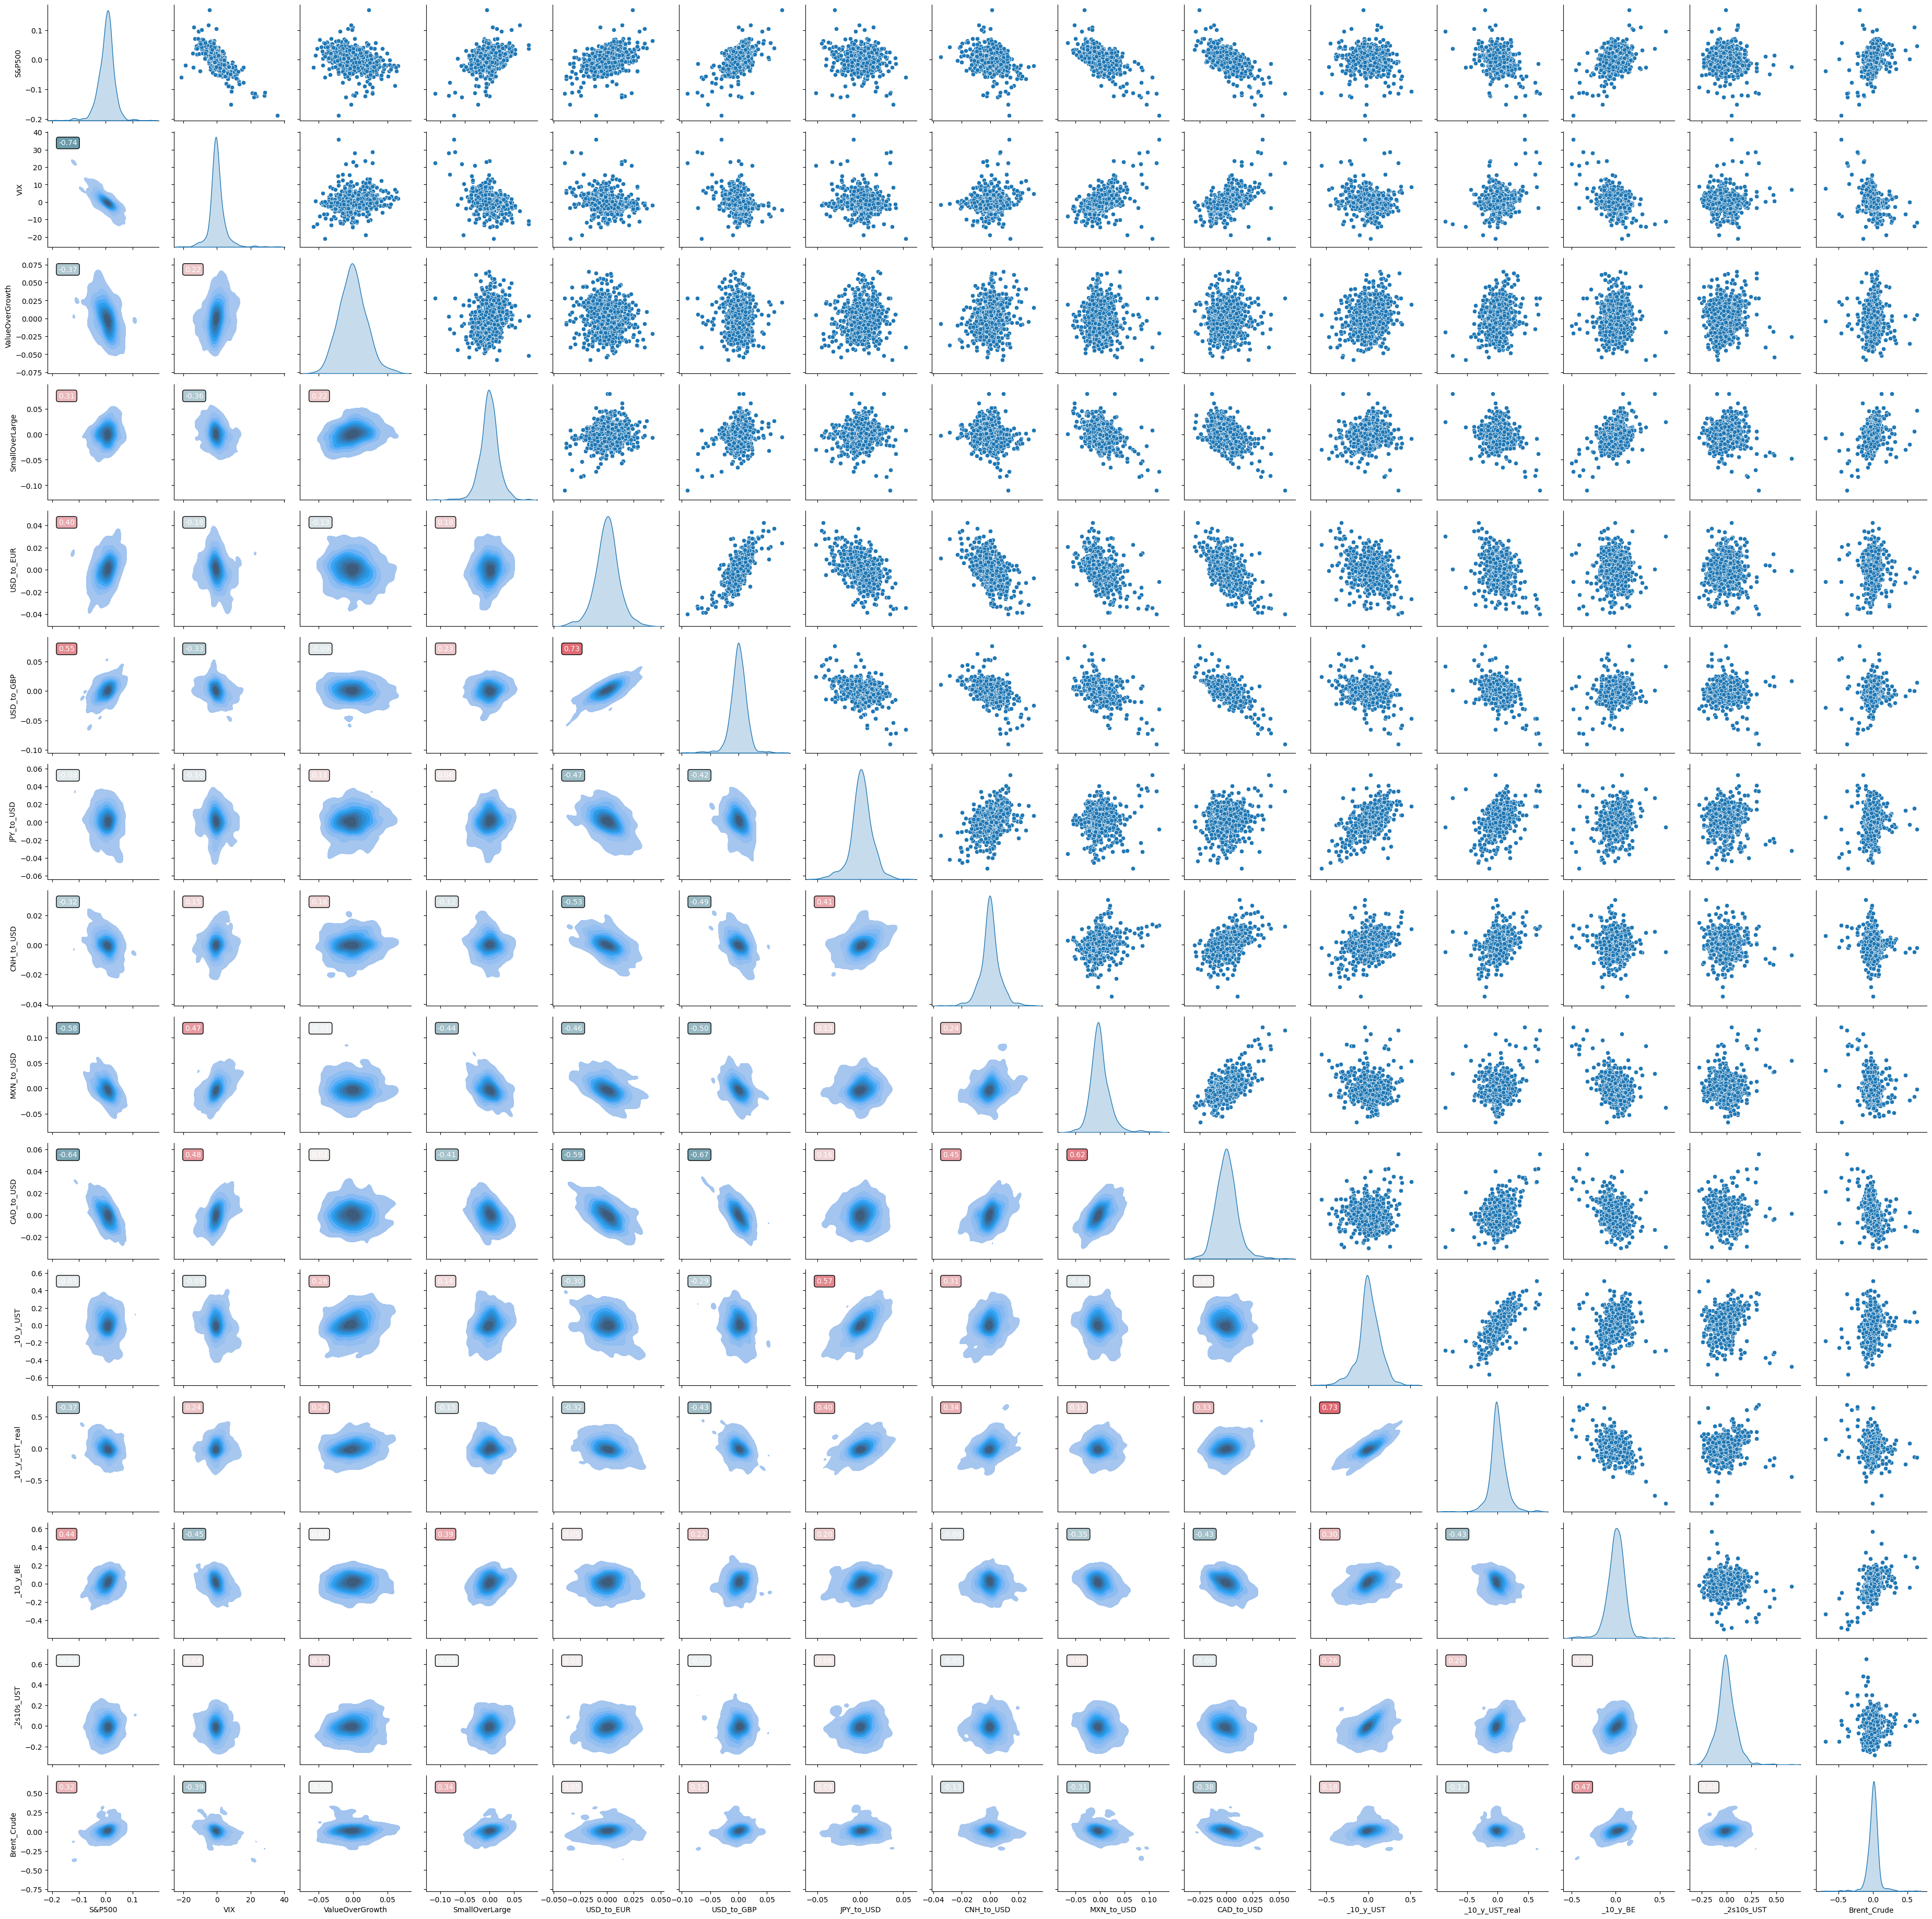

In [27]:
# feature plot changes

warnings.filterwarnings("ignore")

# Load data
df = df_raw_features_slice_chg.iloc[5:]

# Plot time series on diagonal
g = sns.PairGrid(df, diag_sharey=False)

# Add correlation coefficients to lower triangle with colors
corr_matrix = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, j in zip(*np.tril_indices_from(g.axes)):
    if i != j:
        coef = corr_matrix.iloc[i, j]
        g.axes[i, j].annotate(f"{coef:.2f}", (0.1, 0.9), xycoords='axes fraction', ha='left', va='center', color='w', fontsize=10, bbox=dict(boxstyle="round", facecolor=cmap(coef/2 + 0.5), alpha=1))

g.map_upper(sns.scatterplot)
#g.map_lower(sns.histplot, color='steelblue', bins=20, edgecolor='white')
g.map_lower(sns.kdeplot, shade=True)
g.map_diag(sns.kdeplot, shade=True)


plt.show()

warnings.filterwarnings("default")

Looking at the features without 5 day changes (just out of interest)

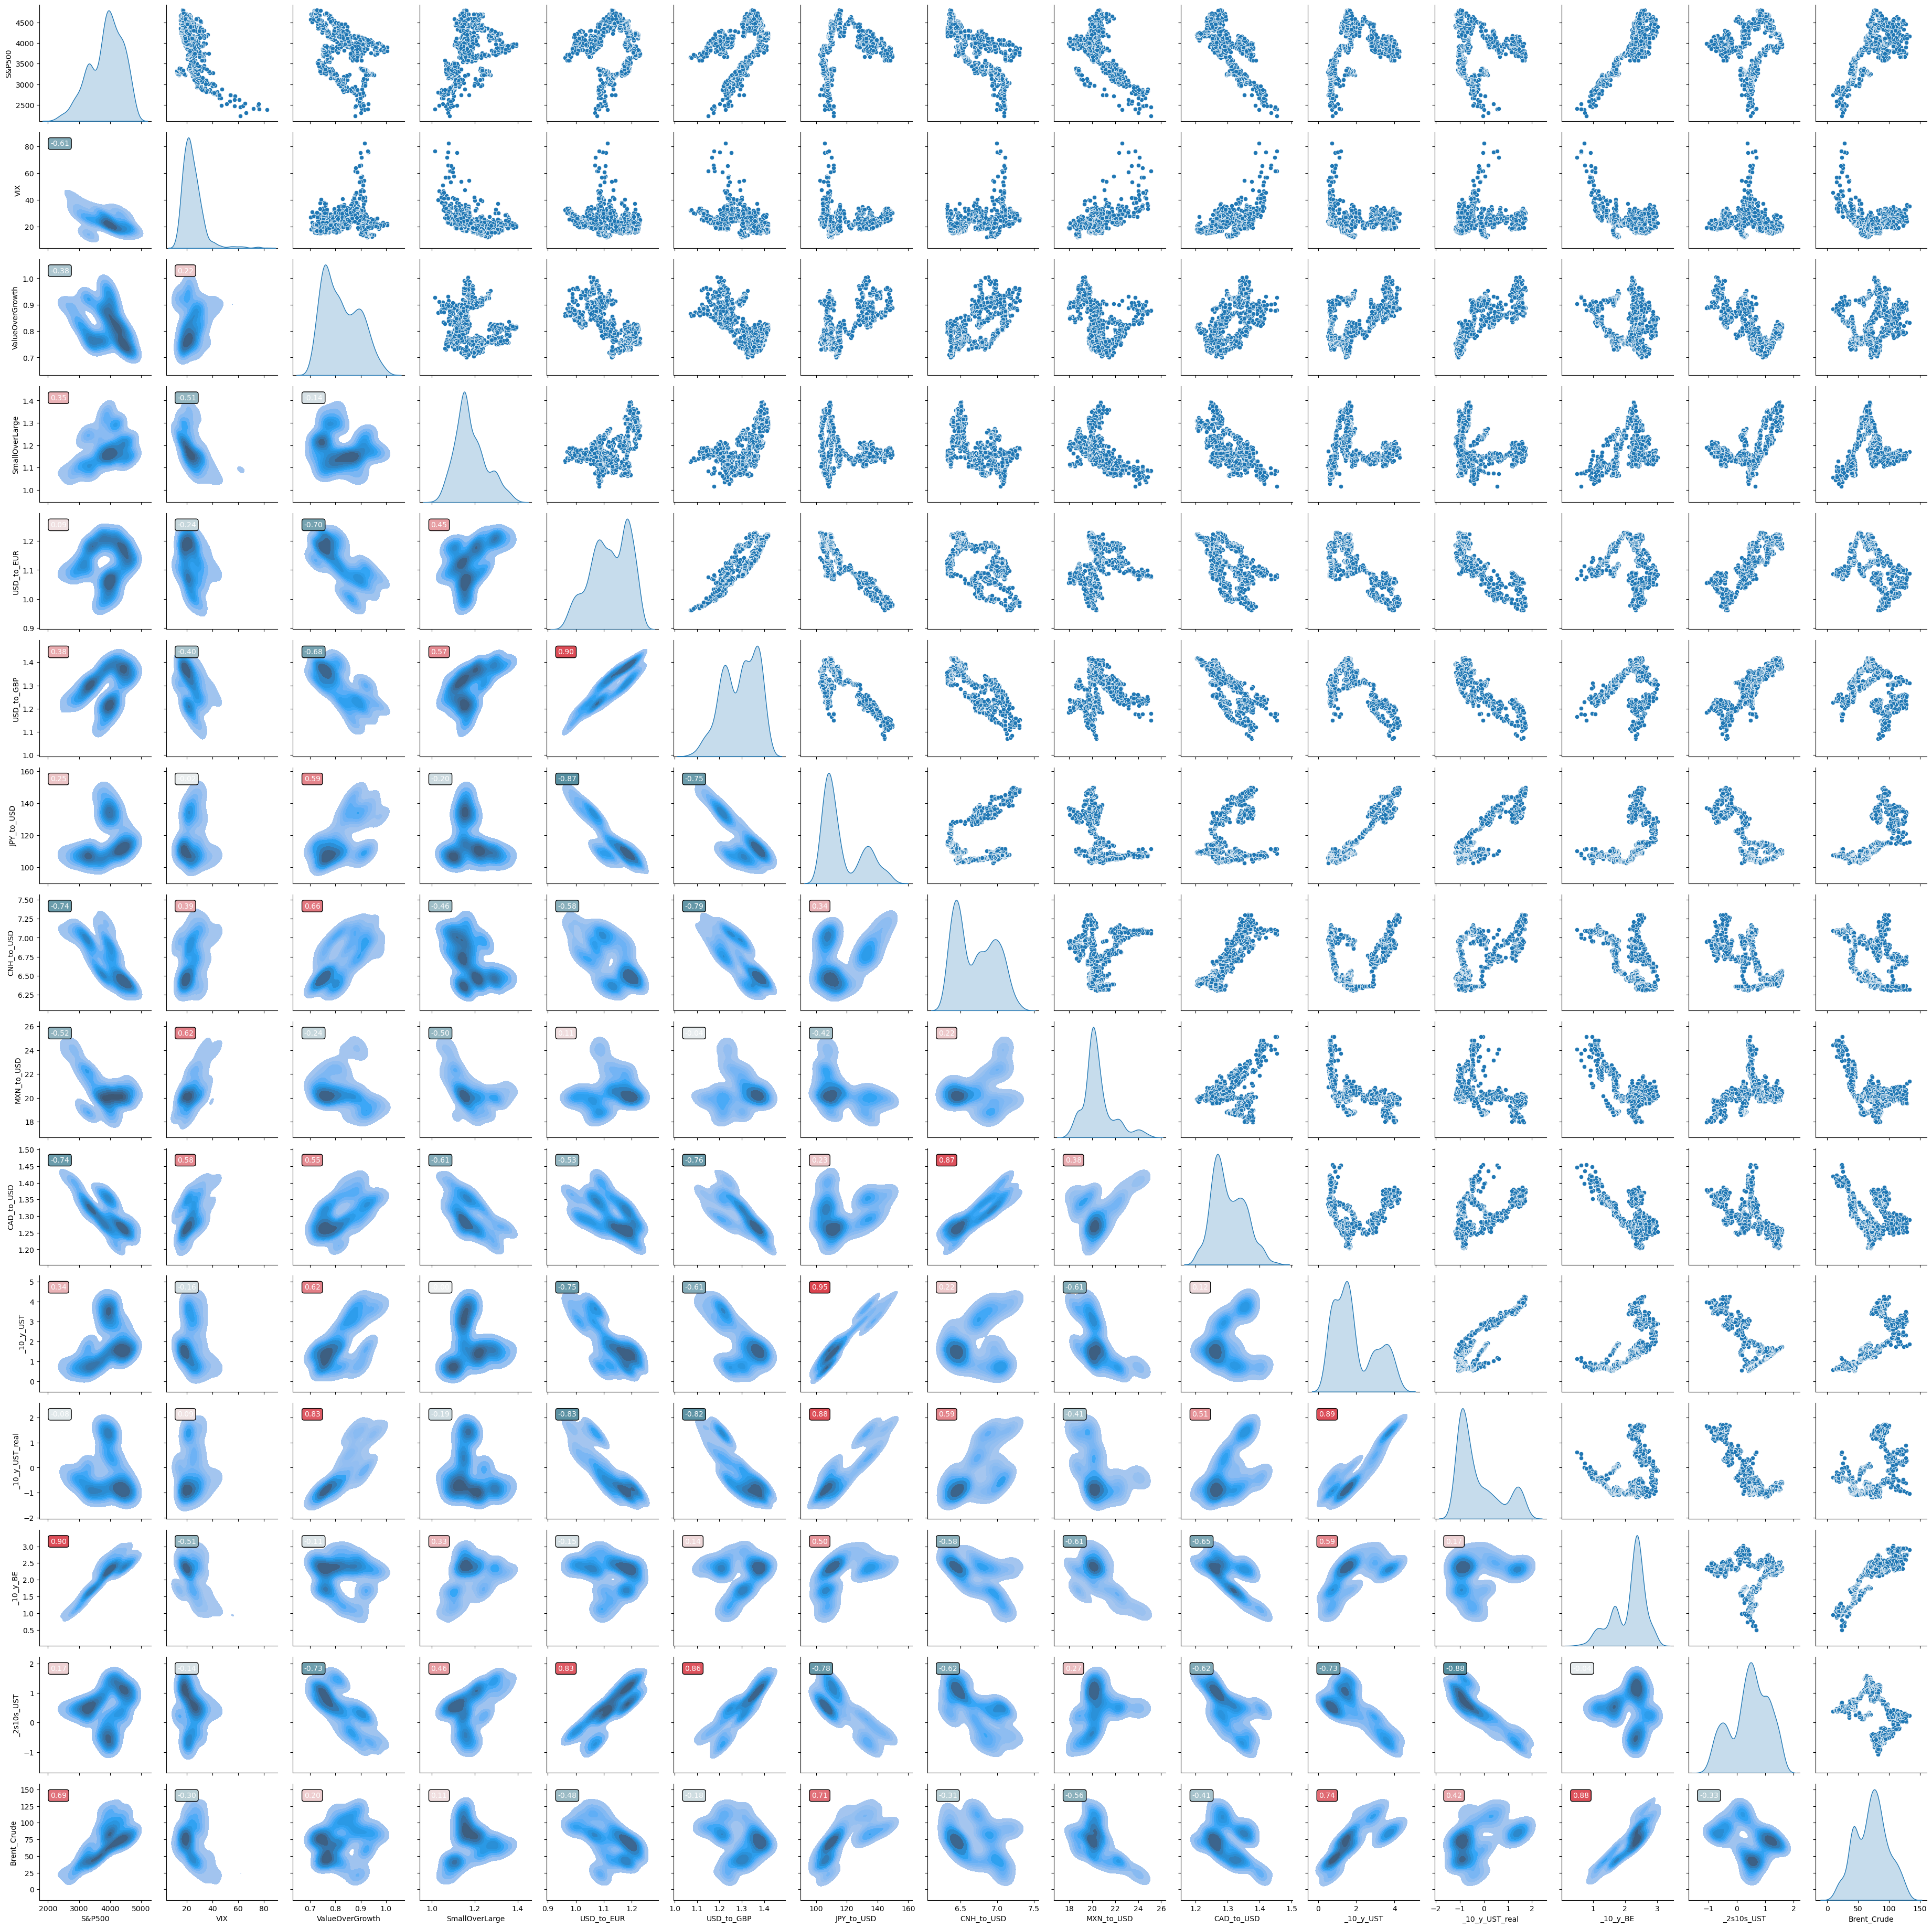

In [28]:
# feature plot 

warnings.filterwarnings("ignore")

# Load data
df = df_raw_features_slice

# Plot time series on diagonal
g = sns.PairGrid(df, diag_sharey=False)

# Add correlation coefficients to lower triangle with colors
corr_matrix = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, j in zip(*np.tril_indices_from(g.axes)):
    if i != j:
        coef = corr_matrix.iloc[i, j]
        g.axes[i, j].annotate(f"{coef:.2f}", (0.1, 0.9), xycoords='axes fraction', ha='left', va='center', color='w', fontsize=10, bbox=dict(boxstyle="round", facecolor=cmap(coef/2 + 0.5), alpha=1))

g.map_upper(sns.scatterplot, cmap=cmap)
g.map_lower(sns.kdeplot, shade=True)
g.map_diag(sns.kdeplot, shade=True)

plt.show()

warnings.filterwarnings("default")

## 7. Merging all raw data to one big dataframe 

In [29]:
# n features
nfeat = df_raw_features_slice_chg.shape[1]

# Rename the index to date
target = target.rename_axis("date")
df_raw_features_slice_chg = df_raw_features_slice_chg.rename_axis("date")

# Convert the index to datetime
target.index = pd.to_datetime(target.index)
df_raw_features_slice_chg.index = pd.to_datetime(df_raw_features_slice_chg.index)

# Merge using left join, based on their index
total_raw_data = target.merge(df_raw_features_slice_chg, how='left', left_index=True, right_index=True)

# Detrend stocks by substracting s&p50
detrende_stocks = (total_raw_data.iloc[:, :-nfeat].sub(total_raw_data["S&P500"], axis=0))#.append(total_raw_data.iloc[:,-nfeat:])

# recreate the dataframe
total_raw_data_dt = pd.concat([detrende_stocks, total_raw_data.iloc[:,-nfeat:]], axis=1)


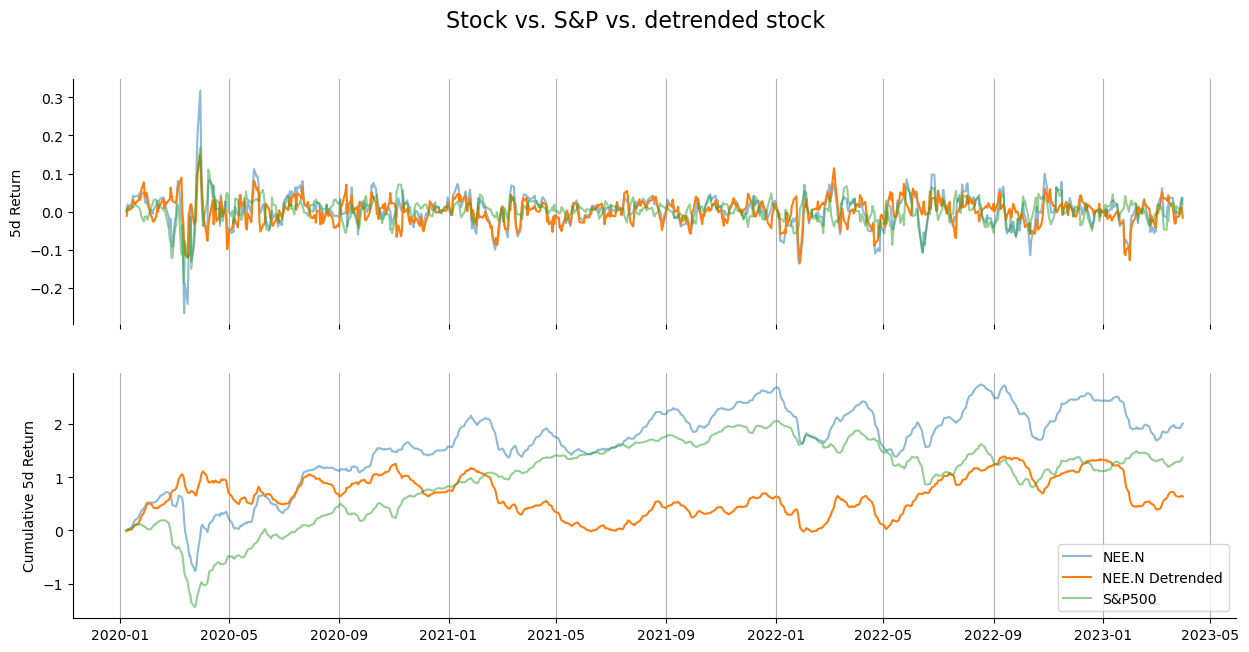

In [30]:
# visualizing the detrending
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))

ax[0].plot(total_raw_data["NEE.N"], alpha=0.5)
ax[0].plot(total_raw_data_dt["NEE.N"])
ax[0].plot(total_raw_data["S&P500"], alpha=0.5)

ax[1].plot(total_raw_data["NEE.N"].cumsum(), label="NEE.N", alpha=0.5)
ax[1].plot(total_raw_data_dt["NEE.N"].cumsum(), label="NEE.N Detrended")
ax[1].plot(total_raw_data["S&P500"].cumsum(), label="S&P500", alpha=0.5)

fig.suptitle("Stock vs. S&P vs. detrended stock", fontsize=16)
ax[0].set_ylabel("5d Return")
ax[0].spines["bottom"].set_visible(False)
ax[0].tick_params(axis='x', which='both', labelbottom=False)
ax[0].xaxis.grid(True)

ax[1].set_ylabel("Cumulative 5d Return")
ax[1].legend(loc="lower right")

for i in range(2):
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].xaxis.grid(True)  # set zorder to 0 to show grid lines below tick marks

plt.show()


# not this is not really a correct time series because it cumulates 5day returns. but for sake of visualizing its ok. 
# we're not using the cumulative time series anyways

## 8. Feature Engineering
the idea is to calculate linear sensitivities of each stock towards the feature. for this, we first normalize all features (z-scores).
Second we calculate the slopes of linear regressions (betas). Those betas will be of similar scale

In [31]:
def data_split(data, start_date, mid_date, end_date, feature_pos):
    first_part = data.loc[start_date:mid_date]
    second_part = data.loc[mid_date:end_date]
    second_part_ex_feats = data.loc[mid_date:end_date].iloc[:,:-feature_pos]

    return first_part, second_part[1:], second_part_ex_feats[1:]

In [32]:
classifying_data, test_data, test_data_ex_feats = data_split(total_raw_data_dt, "2020-01-08", "2022-12-31", "2023-3-31", nfeat)

# save matrices to harddrive
file_name = 'total_raw_data{}.csv'
total_raw_data.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')


In [33]:
# Select the last `nfeat` columns of your dataframe
cols_to_standardize = classifying_data.columns[-nfeat:]
standardized_features = classifying_data[cols_to_standardize].apply(zscore)
stocks = classifying_data.iloc[:,:-nfeat]
classifying_data = pd.concat([stocks,standardized_features], axis=1)

In [34]:
stocks = classifying_data.iloc[:, :-df_raw_features_slice_chg.shape[1]]
variables = classifying_data.iloc[:, -df_raw_features_slice_chg.shape[1]:]
# Create an empty dataframe to store the beta coefficients
betas = pd.DataFrame(index = stocks.columns, 
                     columns=variables.columns)
correls = pd.DataFrame(index = stocks.columns, 
                     columns=variables.columns)

In [35]:
# Loop through the columns of df1 and df2 and calculate the beta coefficients
for col1 in stocks.columns:
    for col2 in variables.columns:
        beta, _, _, _, _ = linregress(variables[col2], stocks[col1])
        betas.loc[col1, col2] = beta
        
# Loop through the columns of df1 and df2 and calculate the correlation coefficients
for col1 in stocks.columns:
    for col2 in variables.columns:
        corr = variables[col2].corr(stocks[col1])
        correls.loc[col1, col2] = corr

# raw beta scaling        
betas_std = np.std(betas.values, axis=None)
betas_mean = np.mean(betas.values, axis=None)

correls_std = np.std(correls.values, axis=None)
correls_mean = np.mean(correls.values, axis=None)

scaled_betas = (betas-betas_mean)/betas_std
scaled_correls = (correls-correls_mean)/correls_std

# merge scaled idiosyncratic features to scaled macro sensitivities
scaled_betas = scaled_betas.join(idio_feats, how = "inner")
scaled_correls = scaled_correls.join(idio_feats, how = "inner")

# calculate the percentile ranks of the values in betas and correls and store it in rank_betas and rank_correls dataframes
ranked_betas = scaled_betas.rank(pct=True)
ranked_correls = scaled_correls.rank(pct=True)

# combined values
mean_scaled = pd.DataFrame(index=scaled_betas.index, columns=scaled_betas.columns)
mean_ranked = pd.DataFrame(index=scaled_betas.index, columns=scaled_betas.columns)
# calculate the mean of the scaled values
mean_scaled = (scaled_betas + scaled_correls) / 2
# calculate the mean of the percentile ranks
mean_ranked = (ranked_betas + ranked_correls) / 2


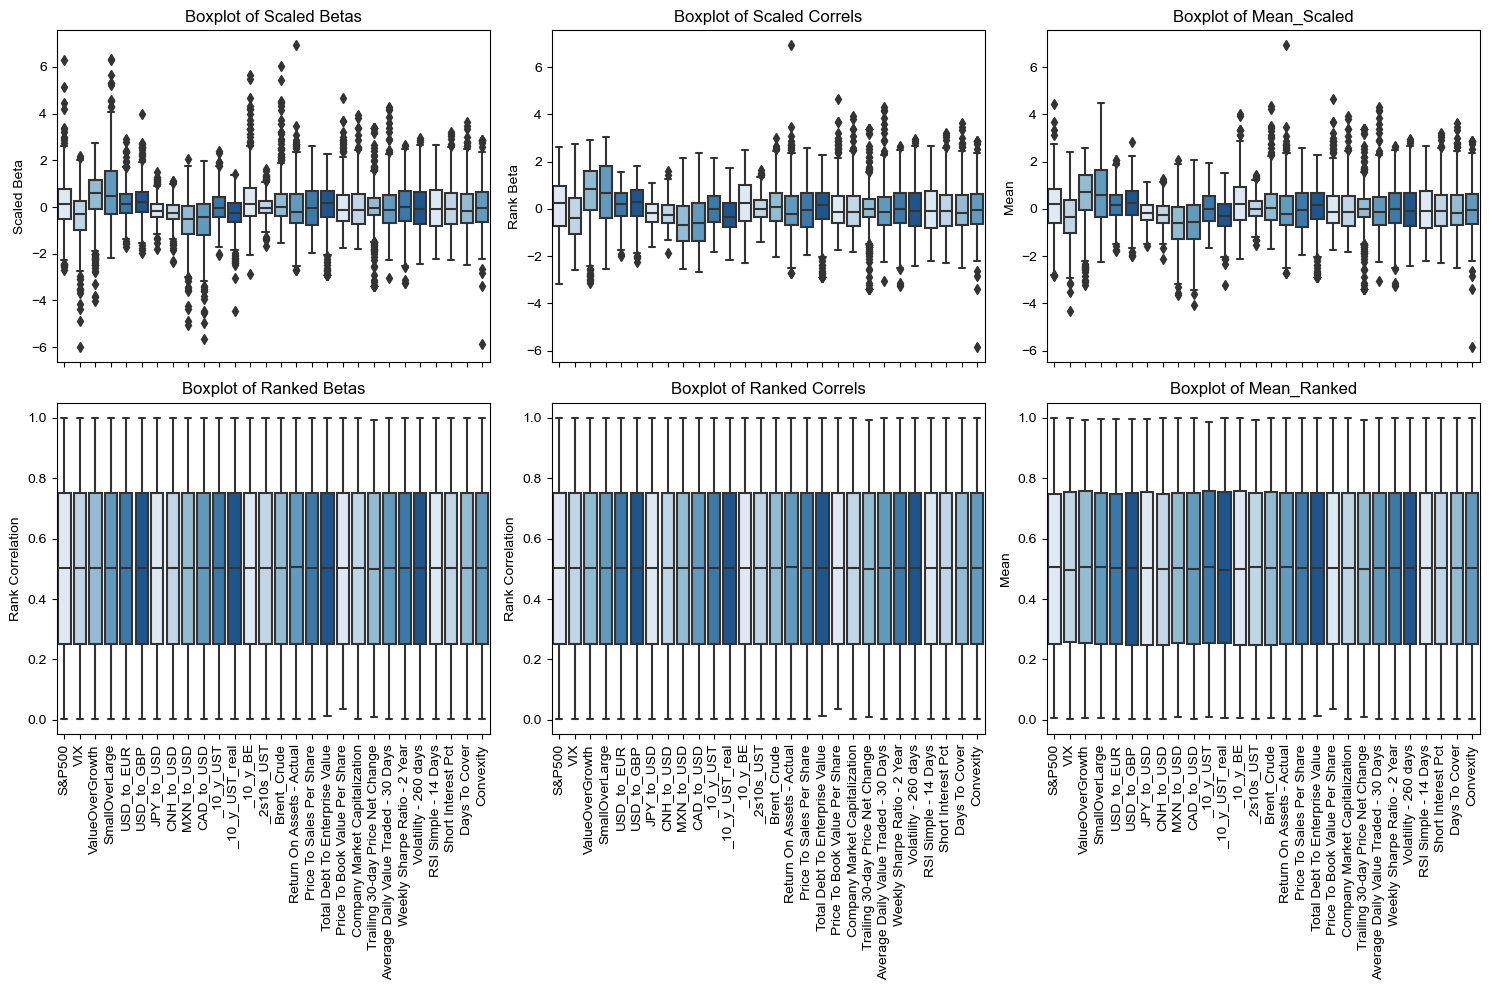

In [36]:
warnings.filterwarnings("ignore")

# Define a blue color palette
colors = sns.color_palette("Blues")

# Create a figure with 5 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

# Set the style for all subplots
sns.set_style("whitegrid")

# Create a boxplot for each column of betas and add it to a subplot


sns.boxplot(data=scaled_betas, ax=axs[0, 0], palette=colors)
axs[0, 0].set_title('Boxplot of Scaled Betas')
axs[0, 0].set_ylabel('Scaled Beta')

sns.boxplot(data=scaled_correls, ax=axs[0, 1], palette=colors)
axs[0, 1].set_title('Boxplot of Scaled Correls')
axs[0, 1].set_ylabel('Rank Beta')

sns.boxplot(data=mean_scaled, ax=axs[0, 2], palette=colors)
axs[0, 2].set_title('Boxplot of Mean_Scaled')
axs[0, 2].set_ylabel('Mean')

sns.boxplot(data=ranked_betas, ax=axs[1, 0], palette=colors)
axs[1, 0].set_title('Boxplot of Ranked Betas')
axs[1, 0].set_ylabel('Rank Correlation')

sns.boxplot(data=ranked_correls, ax=axs[1, 1], palette=colors)
axs[1, 1].set_title('Boxplot of Ranked Correls')
axs[1, 1].set_ylabel('Rank Correlation')

sns.boxplot(data=mean_ranked, ax=axs[1, 2], palette=colors)
axs[1, 2].set_title('Boxplot of Mean_Ranked')
axs[1, 2].set_ylabel('Mean')

# Rotate x-axis labels by 90 degrees for all subplots
for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

# Show the plot
plt.show()



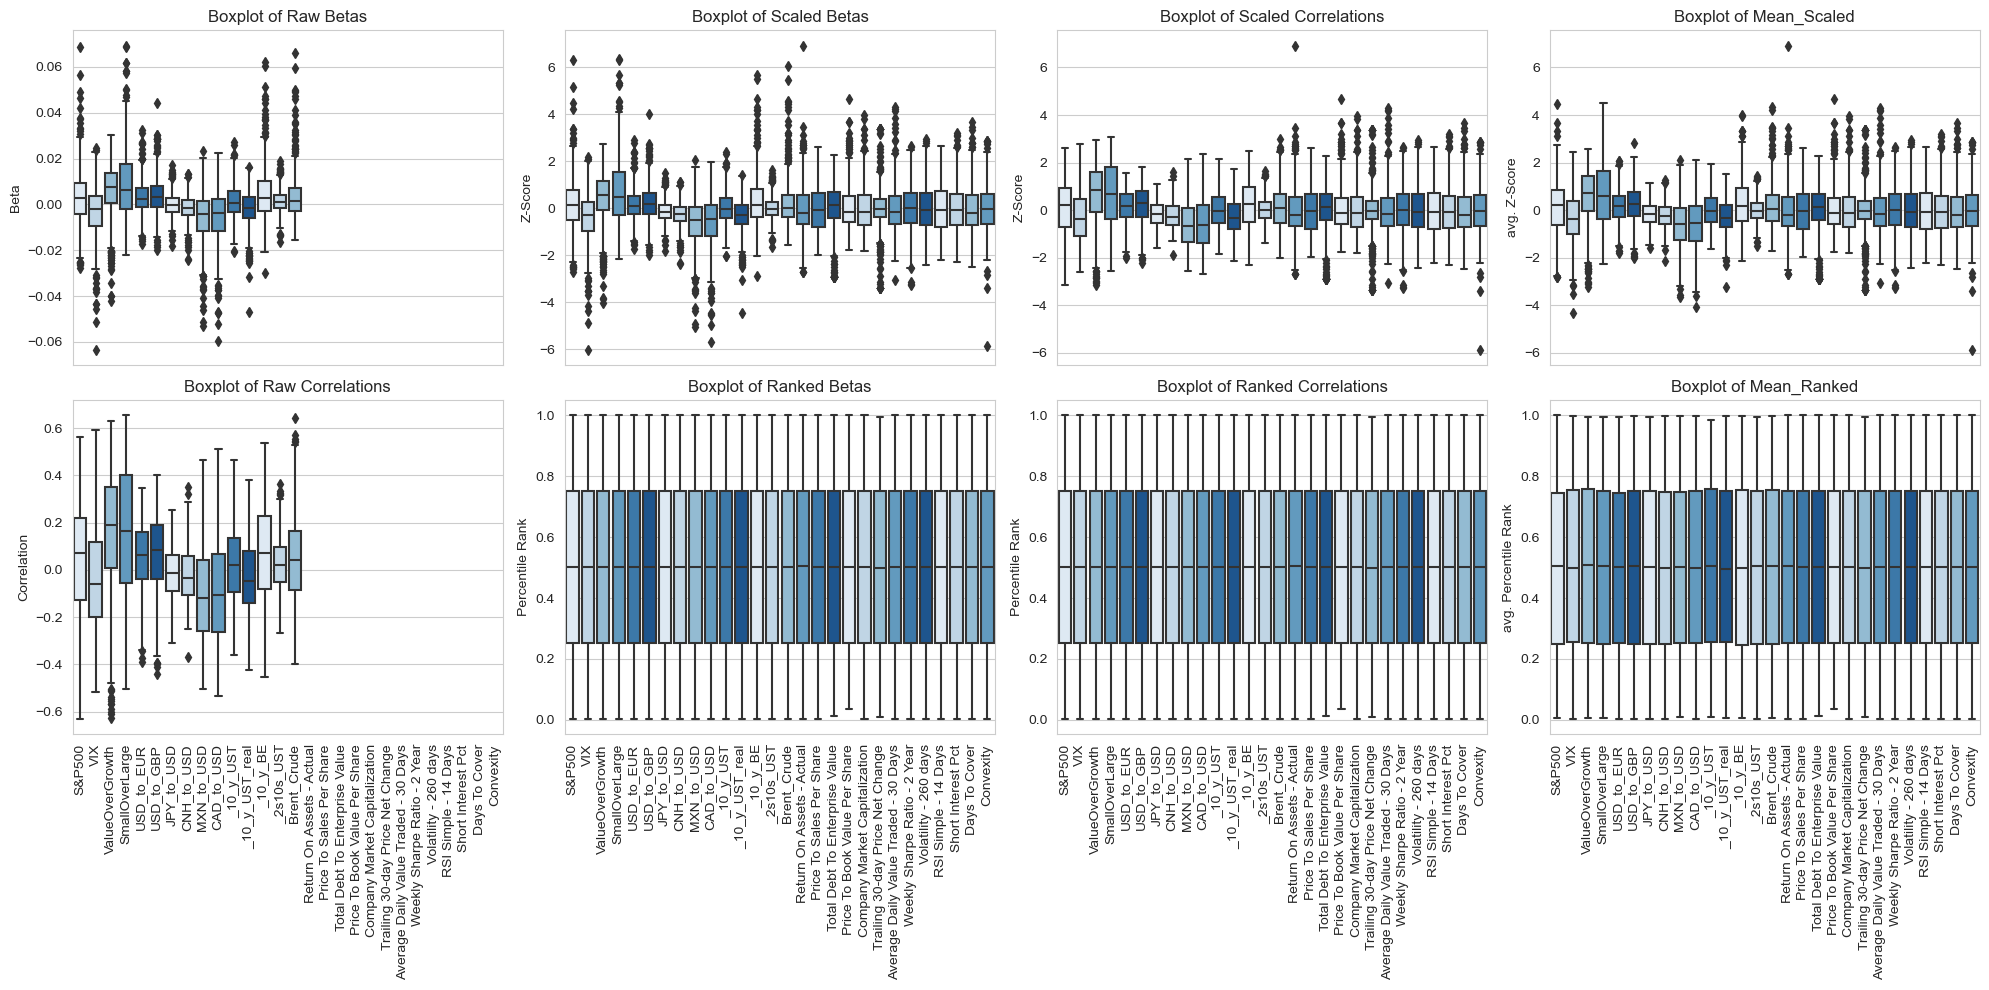

In [37]:
warnings.filterwarnings("ignore")

# Define a blue color palette
colors = sns.color_palette("Blues")

# Create a figure with 5 subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True)

# Set the style for all subplots
sns.set_style("whitegrid")

# Create a boxplot for each column of betas and add it to a subplot
sns.boxplot(data=betas, ax=axs[0, 0], palette=colors)
axs[0, 0].set_title('Boxplot of Raw Betas')
axs[0, 0].set_ylabel('Beta')

sns.boxplot(data=scaled_betas, ax=axs[0, 1], palette=colors)
axs[0, 1].set_title('Boxplot of Scaled Betas')
axs[0, 1].set_ylabel('Z-Score')

sns.boxplot(data=scaled_correls, ax=axs[0, 2], palette=colors)
axs[0, 2].set_title('Boxplot of Scaled Correlations')
axs[0, 2].set_ylabel('Z-Score')

sns.boxplot(data=mean_scaled, ax=axs[0, 3], palette=colors)
axs[0, 3].set_title('Boxplot of Mean_Scaled')
axs[0, 3].set_ylabel('avg. Z-Score')

sns.boxplot(data=correls, ax=axs[1, 0], palette=colors)
axs[1, 0].set_title('Boxplot of Raw Correlations')
axs[1, 0].set_ylabel('Correlation')

sns.boxplot(data=ranked_betas, ax=axs[1, 1], palette=colors)
axs[1, 1].set_title('Boxplot of Ranked Betas')
axs[1, 1].set_ylabel('Percentile Rank')

sns.boxplot(data=ranked_correls, ax=axs[1, 2], palette=colors)
axs[1, 2].set_title('Boxplot of Ranked Correlations')
axs[1, 2].set_ylabel('Percentile Rank')

sns.boxplot(data=mean_ranked, ax=axs[1, 3], palette=colors)
axs[1, 3].set_title('Boxplot of Mean_Ranked')
axs[1, 3].set_ylabel('avg. Percentile Rank')

# Rotate x-axis labels by 90 degrees for all subplots
for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

# Show the plot
plt.show()


## 9. Saving data to Git Repository for further use

In [38]:
# set the file path to where you want to save the DataFrame
path = 'Dataframes/'

In [39]:
# all training data in one df
file_name = 'time_series_train_data_{}.csv'
classifying_data.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

# all test data in one df
file_name = 'time_series_test_data_{}.csv'
test_data.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

# raw data features 
file_name = 'time_series_df_raw_features_{}.csv'
df_raw_features_slice.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

# raw data stocks 
file_name = 'time_series_df_raw_stocks_{}.csv'
result_df_clean.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

## sector mapping names
file_name = 'sector_classes_{}.csv'
sector_classes.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

## sector mapping codes 
file_name = 'sector_classes_code_{}.csv'
sector_classes_code.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')


In [40]:
## stock time series
file_name = 'final_stock_timeseries.csv'
target.round(5).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

In [41]:
## matrices
feature_list_of_dfs = [scaled_betas, ranked_betas, scaled_correls, ranked_correls, mean_scaled, mean_ranked]

file_name = 'final_scaled_betas.csv'
feature_list_of_dfs[0].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

file_name = 'final_ranked_betas.csv'
feature_list_of_dfs[1].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

file_name = 'final_scaled_correls.csv'
feature_list_of_dfs[2].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

file_name = 'final_rank_correls.csv'
feature_list_of_dfs[3].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

file_name = 'final_mean_scaled.csv'
feature_list_of_dfs[4].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')

file_name = 'final_mean_ranked.csv'
feature_list_of_dfs[5].round(3).to_csv(path + file_name, index_label='timestamp', date_format='%Y-%m-%d')
